In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import shutil

In [2]:
# Unggah kaggle.json
from google.colab import files
files.upload()  # Unggah kaggle.json

# Install dan konfigurasi Kaggle API
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Animals-10
!kaggle datasets download -d alessiocorrado99/animals10

# Ekstrak dataset
!unzip animals10.zip -d animals10

# Verifikasi isi
!ls animals10


Streaming output truncated to the last 5000 lines.
  inflating: animals10/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: animals10/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MiVgMXcK

Menampilkan salah satu gambar

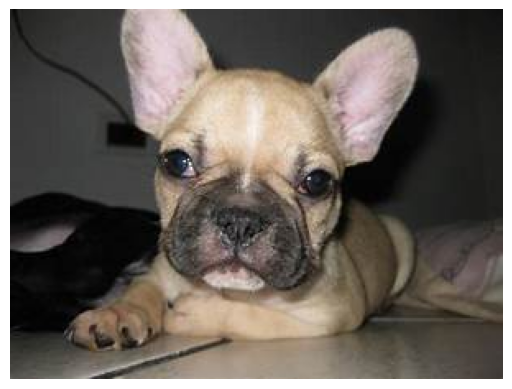

In [3]:
path = '/content/animals10/raw-img/cane'
image_files = os.listdir(path)
img = Image.open(os.path.join(path, image_files[2]))
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# Menerjemahkan label
label_translations = {
    "cane": "dog",
     "cavallo": "horse",
     "elefante": "elephant",
     "farfalla": "butterfly",
     "gallina": "chicken",
     "gatto": "cat",
     "mucca": "cow",
     "pecora": "sheep",
     "scoiattolo": "squirrel",
     "ragno": "spider"

}

# Create a dictionary to store the translated folder names
translated_folder_names = {}
for folder_name, translation in label_translations.items():
  translated_folder_names[folder_name] = translation

# Print the translated folder names
translated_folder_names


base_dir = '/content/animals10/raw-img' # Replace with your actual folder path
for folder_name, translation in translated_folder_names.items():
  old_path = os.path.join(base_dir, folder_name)
  new_path = os.path.join(base_dir, translation)
  if os.path.exists(old_path):
    try:
      os.rename(old_path, new_path)
      print(f"Renamed folder '{folder_name}' to '{translation}'")
    except OSError as e:
      print(f"Error renaming folder '{folder_name}': {e}")
  else:
    print(f"Folder '{folder_name}' not found.")


Renamed folder 'cane' to 'dog'
Renamed folder 'cavallo' to 'horse'
Renamed folder 'elefante' to 'elephant'
Renamed folder 'farfalla' to 'butterfly'
Renamed folder 'gallina' to 'chicken'
Renamed folder 'gatto' to 'cat'
Renamed folder 'mucca' to 'cow'
Renamed folder 'pecora' to 'sheep'
Renamed folder 'scoiattolo' to 'squirrel'
Renamed folder 'ragno' to 'spider'


In [5]:
# Bagi setiap folder menjadi 80% data training 10% untuk validasi 10% test.

def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
  """Splits data into training, validation, and testing sets."""

  # Check if ratios sum to 1.0 and raise an error if not
  if train_ratio + val_ratio + test_ratio != 1.0:
    raise ValueError("Ratios must sum to 1.0")

  for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)
    if not os.path.isdir(folder_path):
      continue

    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)
    random.shuffle(images)  # Shuffle images randomly

    train_split = int(num_images * train_ratio)
    val_split = int(num_images * (train_ratio + val_ratio))


    # Create destination directories if they don't exist
    os.makedirs(os.path.join(train_dir, folder_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder_name), exist_ok=True)


    for i, image in enumerate(images):
        source_image_path = os.path.join(folder_path, image)

        if i < train_split:
            destination_folder = os.path.join(train_dir, folder_name)
        elif i < val_split:
            destination_folder = os.path.join(val_dir, folder_name)
        else:
            destination_folder = os.path.join(test_dir, folder_name)

        destination_image_path = os.path.join(destination_folder, image)
        shutil.copy(source_image_path, destination_image_path)

# Example usage:
source_directory = '/content/animals10/raw-img'
train_directory = '/content/animals10/train'
validation_directory = '/content/animals10/val'
test_directory = '/content/animals10/test'

split_data(source_directory, train_directory, validation_directory, test_directory, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

In [6]:
# Menampilkan jumlah data split

def count_images_in_split(directory):
    """Counts the number of images in each subdirectory of a given directory."""
    total_images = 0
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            total_images += len(images)
    return total_images

train_count = count_images_in_split('/content/animals10/train')
val_count = count_images_in_split('/content/animals10/val')
test_count = count_images_in_split('/content/animals10/test')

print(f"Jumlah gambar di set pelatihan: {train_count}")
print(f"Jumlah gambar di set validasi: {val_count}")
print(f"Jumlah gambar di set pengujian: {test_count}")


Jumlah gambar di set pelatihan: 20938
Jumlah gambar di set validasi: 2618
Jumlah gambar di set pengujian: 2623


In [7]:
# prompt: cek ukuran gambar
def check_image_size(image_path):
  """Checks the size of an image file.

  Args:
    image_path: The path to the image file.

  Returns:
    A tuple containing the width and height of the image, or None if the file
    is not a valid image or cannot be opened.
  """
  try:
    with Image.open(image_path) as img:
      width, height = img.size
      return width, height
  except (FileNotFoundError, OSError, IOError):
    print(f"Error: Could not open or read image file '{image_path}'")
    return None

# Example usage:
path = '/content/animals10/raw-img/dog'
image_files = os.listdir(path)

for image_file in image_files:
  image_path = os.path.join(path, image_file)
  dimensions = check_image_size(image_path)
  if dimensions:
    width, height = dimensions
    print(f"Image '{image_file}': Width = {width}, Height = {height}")


Image 'OIP-K3uLMvo1rUfVscOsceW8ZAHaE8.jpeg': Width = 300, Height = 200
Image 'OIP-aRUK_mhelJPA-gjSY4M4dwHaGR.jpeg': Width = 300, Height = 254
Image 'OIP-Cbb2_Tdpmq-_1bETmTiP3gHaFj.jpeg': Width = 300, Height = 225
Image 'OIP-EPAEHVHgN9bRPhdXrAelQQHaE8.jpeg': Width = 300, Height = 200
Image 'OIP-ODQuuuTKTsX7evGRvx23pgHaFj.jpeg': Width = 300, Height = 225
Image 'OIP-761rj4Nr0fJjhG0rxRDVPQHaE6.jpeg': Width = 300, Height = 199
Image 'OIP-DD8P_F4D2DSNU2BbeQGHYAAAAA.jpeg': Width = 300, Height = 250
Image 'OIP-3Viz--nA1-To-iRrG70i7wAAAA.jpeg': Width = 224, Height = 300
Image 'OIP-k2__Q7xhfKFi77X4c4-DNwHaE8.jpeg': Width = 300, Height = 200
Image 'OIP-qrkFEPiltuPMeyKm2067rAHaGj.jpeg': Width = 300, Height = 266
Image 'OIP-_2iBsOsobKZsP76-9Cd-qAHaEM.jpeg': Width = 300, Height = 170
Image 'OIP-GqGstgv9bBvXWNmnokbv_wHaF7.jpeg': Width = 300, Height = 240
Image 'OIP-gx3BqKmXdxF6KAhrBRVxWAHaFj.jpeg': Width = 300, Height = 225
Image 'OIP-rP-TIds3P3w_BmyBu5MYKgHaFj.jpeg': Width = 300, Height = 225
Image 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    '/content/animals10/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',

)

val_data = datagen.flow_from_directory(
    '/content/animals10/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',

)

test_data = datagen.flow_from_directory(
    '/content/animals10/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',

)


Found 20938 images belonging to 10 classes.
Found 2618 images belonging to 10 classes.
Found 2623 images belonging to 10 classes.


In [9]:
# Transfer learning dengan MobileNetV2
def create_pretrained_model():

  pretrained_model = MobileNetV2(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet')

  pretrained_model.trainable = False

  return pretrained_model

In [10]:
pretrained_model = create_pretrained_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# Menampilkan model summary
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Menggunakan callback jika akurasi training dan validasi mencapai 95%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.95:
            self.model.stop_training = True
            print("\nReached 95% accuracy so cancelling training!")

In [17]:
# Mendefinisikan model sekuensial
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    pretrained_model,
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')  # karna ada 10 class
])


In [18]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Pakai categorical karena ImageDataGenerator
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,592,074 (13.70 MB)

 Trainable params: 1,333,962 (5.09 MB)

 Non-trainable params: 2,258,112 (8.61 MB)

In [20]:
# Melakukan training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    verbose=1,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.8291 - loss: 0.6767 - val_accuracy: 0.9515 - val_loss: 0.1597
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9584 - loss: 0.1341
Reached 95% accuracy so cancelling training!
655/655 ━━━━━━━━━━━━━━━━━━━━ 65s 77ms/step - accuracy: 0.9584 - loss: 0.1341 - val_accuracy: 0.9530 - val_loss: 0.1677


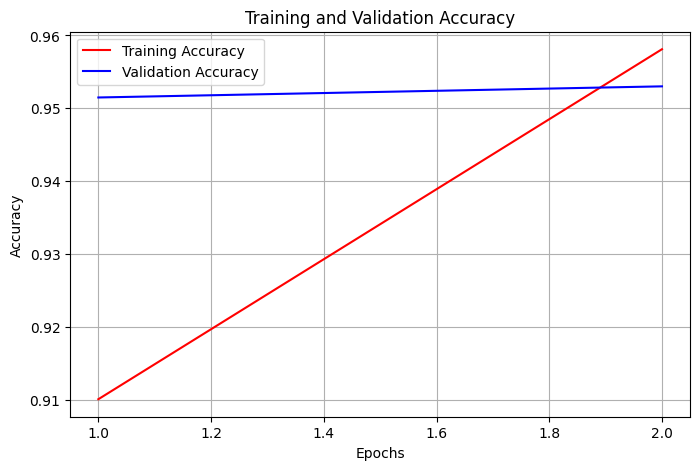

In [21]:
# Ambil data history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)  # Mulai dari epoch 1

# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [22]:
# Evaluasi model di data tes
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Membuat prediksi
predictions = model.predict(test_data)

# Ambil prediksi kelas
predicted_labels = np.argmax(predictions, axis=1)

# Mengambil kelas yang sebenarnya
true_labels = test_data.classes

# Menampilkan hasil klasifikasi
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9482 - loss: 0.1817
Test Loss: 0.1641
Test Accuracy: 0.9516
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step
              precision    recall  f1-score   support

           0       0.07      0.07      0.07       212
           1       0.04      0.04      0.04       167
           2       0.12      0.11      0.11       310
           3       0.09      0.09      0.09       187
           4       0.19      0.20      0.19       487
           5       0.06      0.07      0.07       145
           6       0.10      0.10      0.10       263
           7       0.06      0.05      0.06       182
           8       0.20      0.21      0.21       483
           9       0.08      0.08      0.08       187

    accuracy                           0.13      2623
   macro avg       0.10      0.10      0.10      2623
weighted avg       0.12      0.13      0.13      2623



In [ ]:
# Menyimpan model ke dalam format SavedModel
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)

In [24]:
# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Menyimpan TensorFlow Lite model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [25]:
import json

# Ambil class indices dari ImageDataGenerator
labels = train_data.class_indices
labels = {v: k for k, v in labels.items()}  # Balikin jadi index -> label

# Simpan ke file labels.txt
with open("labels.txt", "w") as f:
    for i in range(len(labels)):
        f.write(f"{labels[i]}\n")


In [26]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [27]:
# Konversi model ke TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model saved_model ./tfjs_model


2025-03-06 12:42:53.217495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741264973.255223    5010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741264973.266901    5010 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-06 12:43:06.101672: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1741264986.101925    5010 gpu_device.cc:2022] Created device /job:localhost/replica:0/task